<a href="https://colab.research.google.com/github/pachterlab/BI-BE-CS-183-2023/blob/main/HW10/HW10Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 10 Final Problem**

In this problem you will process a single-cell dataset from the raw fastqs (sequencing reads of the cDNA library) to produce the cell x gene count matrix we usually work with. Given this count matrix you will additionally investigate the impact of various normalization techniques and dimensionality reduction on clustering of the cells (i.e. looking for cell types). With the metadata for this dataset, the cell types and ages of the mice used, you will then compare the efficacy of logistic regression vs neural network based techniques for classifying the age of the mouse a cell came from.


##**Install packages**

Install kb-python

This package is used to do transcript quantification (as shown in HW 4 Problem 2), aligning sequencing reads to a provided transcriptome to estimate transcript abundances. This produces the gene count matrices we have been working with. kb takes in the raw FASTQ files (the cDNA sequences from the generated cDNA library), aligns the transcript sequences to a reference file for the organism (the kallisto index below), and generates a count matrix of the transcripts (or genes) per cell.

In [1]:
# Install kb. This package runs kallisto and bustools. 
# These are programs used to process the single-cell RNA-seq reads to produce count matrices.
!pip3 install kb-python 

In [2]:
!pip3 install --quiet anndata
!pip install --quiet scanpy==1.7.0rc1

In [2]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

import anndata
import scanpy as sc

In [3]:
import time
t=time.time()

## **Read in data for Part a) analysis**
#### Running the code for data downloading and count matrix generation may take ~20mins total.

In [4]:
# Download the data from the ENA for a 3-month mouse
# This step should take 5-10mins
!wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/002/SRR8426372/SRR8426372_1.fastq.gz
!wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/002/SRR8426372/SRR8426372_2.fastq.gz

--2023-03-14 12:44:29--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/002/SRR8426372/SRR8426372_1.fastq.gz
           => ‘SRR8426372_1.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/fastq/SRR842/002/SRR8426372 ... done.
==> SIZE SRR8426372_1.fastq.gz ... 2389120304
File has already been retrieved.
2023-03-14 12:44:32 (0.00 B/s) - ‘SRR8426372_1.fastq.gz’ saved [2389120304]

--2023-03-14 12:44:32--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/002/SRR8426372/SRR8426372_2.fastq.gz
           => ‘SRR8426372_2.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  

Download a kallisto index 


In [6]:
!kb ref -d mouse -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2023-03-14 12:39:29,472]    INFO [download] Skipping download because some files already exist. Use the --overwrite flag to overwrite.


Generate the cell x gene count matrix

In [5]:
# This command processes previously downloaded data
# This step should take ~11mins
!kb count --h5ad -i index.idx -g t2g.txt -x Dropseq -o output --filter bustools -t 2 \
SRR8426372_1.fastq.gz \
SRR8426372_2.fastq.gz


[2023-03-14 12:44:44,681]    INFO [count] Skipping kallisto bus because output files already exist. Use the --overwrite flag to overwrite.
[2023-03-14 12:44:44,681]    INFO [count] Sorting BUS file output/output.bus to output/tmp/output.s.bus
[2023-03-14 12:45:08,605]    INFO [count] Whitelist not provided
[2023-03-14 12:45:08,605]    INFO [count] Generating whitelist output/whitelist.txt from BUS file output/tmp/output.s.bus
[2023-03-14 12:45:09,910]    INFO [count] Inspecting BUS file output/tmp/output.s.bus
[2023-03-14 12:45:11,716]    INFO [count] Correcting BUS records in output/tmp/output.s.bus to output/tmp/output.s.c.bus with whitelist output/whitelist.txt
[2023-03-14 12:45:18,434]    INFO [count] Sorting BUS file output/tmp/output.s.c.bus to output/output.unfiltered.bus
[2023-03-14 12:45:25,858]    INFO [count] Generating count matrix output/counts_unfiltered/cells_x_genes from BUS file output/output.unfiltered.bus
[2023-03-14 12:45:31,253]    INFO [count] Reading matrix outpu

**The dataset**

This is a Drop-seq based single-cell RNA-seq dataset produced from tissue extracted from the whole mouse lung, published by [Ilias Angelidis, Lukas M. Simon et al. 2019](https://www.nature.com/articles/s41467-019-08831-9). In the study single-cell suspensions were generated from eight 3-month old mice and seven 24-month old mice and looked for cell type specific effects of aging between the mice i.e. to create a single-cell atlas of the aging lung. 

For Part a we will only be working with one sample from a 3-month old mouse (though in Parts b-d you will work with the full dataset across both ages and all mice).

<center><img src="https://drive.google.com/uc?export=view&id=1O_x3hmDDes7foQVVLcoZVasrVED1L0Al" alt="EMFigure" width="900" height="150"><center>

**The count matrix**

This matrix is 3,839 cells by 55,421 genes for one lung sample from a 3-month old mouse.




In [6]:
# load the raw cell x gene count matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad") #This is the output from kb
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t") #Load the transcipt-to-gene name mapping (t2g)
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [7]:
adata

AnnData object with n_obs × n_vars = 3839 × 55421
    var: 'gene_name', 'gene_id'

In [8]:
count_mat = adata.X #Get the count matrix from this anndata object
count_mat.shape

(3839, 55421)

**Use this count_mat for Part a.**

# **a) Pre-processing: Select real/valid cells i.e. cells that pass a UMI count threshold based on the commonly used 'Knee plot'. (10 points)**

Knee plots (described below) are commonly used to filter out cell barcodes that likely correspond to empty droplets that were captured or noisy samples that may be just ra
ndom transcripts that were picked up in the droplet. We want to only keep cell barcodes that seem to have high enough UMI counts (i.e. molecules detected) which suggest that a real cell was captured in that droplet.

**To construct a knee plot** we (1) rank cells in *descending* order of their total UMI counts (UMI counts summed across genes). The cell rankings are plotted on the x axis (1 to n cells). On the y-axis we (2) plot the total UMI count of each cell. Thus as we move across the x-axis from left to right, the right end of the plot displays cells with very few UMI counts (noisy/empty droplets to possibly remove from analysis). Often the x and y axis are plotted in a log-log plot.

The inflection point of the graph denotes a separation/drop between the lefthand side of the plot where cell barcodes have high UMI counts and the righthand side where cell barcodes have low associated UMI counts (and are thus considered to have had failure in capture and/or to be too noisy for further analysis.)

**(1) Make one knee plot for the 3,839 cells (which are the cell barcodes) and their total UMI counts across the 55,421 genes (in a log-log plot). (2) Describe what UMI threshold you might use to filter out noisy cell barcodes based on the plot.**

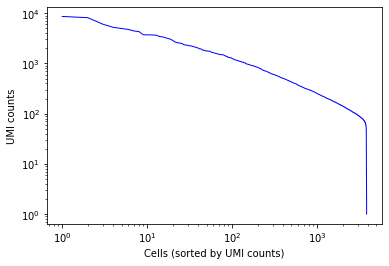

In [9]:

# calculate the total UMI count for each cell
total_counts = np.sum(count_mat, axis=1)

# sort cells by their total UMI counts
sorted_counts = np.sort(total_counts, axis=0)[::-1]

# plot the sorted UMI counts
fig, ax = plt.subplots()
ax.plot(np.array(range(len(sorted_counts))) + 1, sorted_counts, 'b-', linewidth=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Cells (sorted by UMI counts)')
ax.set_ylabel('UMI counts')
plt.show()

elbow around 50ish

# **Read in data for Parts b-d analysis**

For Parts b-d you will be using the full gene count matrix across the 3-month and 24-month mouse cells combined, as provided in the original paper, which is 14,813 cells × 21,969 genes. We will filter for the top 2000 highly variable genes, so that you can use this matrix within the Colab environment. (Downloaded below)

In [12]:
#Read in full cell x gene count matrix for 3 and 24 month old mice lung samples
!wget --content-disposition https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_raw_counts_single_cell.mtx.gz

--2023-03-14 12:40:45--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_raw_counts_single_cell.mtx.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 165.112.9.230, 2607:f220:41f:250::228, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20074662 (19M) [application/x-gzip]
Saving to: ‘GSE124872_raw_counts_single_cell.mtx.gz.1’

GSE124872_raw_count 100%[===================>]  19.14M  8.79MB/s    in 2.2s    

2023-03-14 12:40:47 (8.79 MB/s) - ‘GSE124872_raw_counts_single_cell.mtx.gz.1’ saved [20074662/20074662]



In [13]:
#Read in cell metadata
!wget --content-disposition https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_Angelidis_2018_metadata.csv.gz

--2023-03-14 12:40:48--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE124nnn/GSE124872/suppl/GSE124872_Angelidis_2018_metadata.csv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 165.112.9.228, 165.112.9.230, 2607:f220:41f:250::228, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|165.112.9.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 188271 (184K) [application/x-gzip]
Saving to: ‘GSE124872_Angelidis_2018_metadata.csv.gz.1’

GSE124872_Angelidis 100%[===================>] 183.86K   999KB/s    in 0.2s    

2023-03-14 12:40:49 (999 KB/s) - ‘GSE124872_Angelidis_2018_metadata.csv.gz.1’ saved [188271/188271]



In [14]:
!gunzip GSE124872_Angelidis_2018_metadata.csv.gz
!gunzip GSE124872_raw_counts_single_cell.mtx.gz

gzip: GSE124872_Angelidis_2018_metadata.csv already exists; do you wish to overwrite (y or n)? ^C
gzip: GSE124872_raw_counts_single_cell.mtx already exists; do you wish to overwrite (y or n)? 

Read in metadata of cells: "grouping" denotes the age (3m - 3 month, 24m - 24 month) and "celltype" denotes the cell type e.g. Plasma_cells

In [10]:
meta = pd.read_csv('GSE124872_Angelidis_2018_metadata.csv')
meta.head()

,Unnamed: 0,nGene,nUMI,orig.ident,identifier,res.2,identifier.1,name,grouping,batch,cells,cluster,celltype
0,muc3838:muc3838:TTCCGTGCCCCT,4255,10691,merged,muc3838,2,muc3838,NaN,24m,good,800,cluster2,Ciliated_cells
1,muc3838:muc3838:TTGCCCAATTAA,3178,6860,merged,muc3838,2,muc3838,NaN,24m,good,800,cluster2,Ciliated_cells
2,muc3838:muc3838:AAGCCCAGCTAT,1470,6127,merged,muc3838,24,muc3838,NaN,24m,good,800,cluster24,Plasma_cells
3,muc3838:muc3838:GCACTTTAGAAT,2348,4359,merged,muc3838,2,muc3838,NaN,24m,good,800,cluster2,Ciliated_cells
4,muc3838:muc3838:TCCTGCTCCCTT,2439,5293,merged,muc3838,2,muc3838,NaN,24m,good,800,cluster2,Ciliated_cells


**The dataset**

This is a Drop-seq based single-cell RNA-seq dataset produced from tissue extracted from the whole mouse lung, published by [Ilias Angelidis, Lukas M. Simon et al. 2019](https://www.nature.com/articles/s41467-019-08831-9). In the study single-cell suspensions were generated from eight 3-month old mice and seven 24-month old mice and looked for cell type specific effects of aging between the mice i.e. to create a single-cell atlas of the aging lung. 

For Parts b-c we will only be working with the full dataset across both ages and all mice.

<center><img src="https://drive.google.com/uc?export=view&id=1O_x3hmDDes7foQVVLcoZVasrVED1L0Al" alt="EMFigure" width="900" height="150"><center>

**The count matrix**

This matrix is 14,813 cells by 21,969 genes across all mouse lung samples as provided in Ilias Angelidis, Lukas M. Simon et al. 2019.




Read in count matrix

In [11]:
import scipy.io as sio
count_mat = sio.mmread('GSE124872_raw_counts_single_cell.mtx')
count_mat = count_mat.todense().T
count_mat.shape

(14813, 21969)

Select for top 2000 highly variable genes

In [12]:
#Anndata is a common data type for processing and storing single-cell count matrices
adata = anndata.AnnData(X = count_mat)
adata

/tmp/ipykernel_25702/2902434464.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X = count_mat)


AnnData object with n_obs × n_vars = 14813 × 21969

In [13]:
#Select the 'highly variable' genes in the matrix so we don't use 21k genes
sc.pp.filter_cells(adata, min_counts=0)
sc.pp.filter_genes(adata, min_counts=0)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #Cell-size normalization
sc.pp.log1p(adata) #log-variance stabilization

sc.pp.highly_variable_genes(adata,n_top_genes=2000)

genesToKeep = adata.var['highly_variable']

In [14]:
#Subset original count matrix
count_mat = count_mat[:,genesToKeep]
count_mat.shape

(14813, 2000)

**Use this 14813 × 2000 count_mat matrix as your count matrix for parts b-d**

# **b) Normalization (10 points)**

Note that we use cell size normalization and then log1p to transform data before selecting highly variable genes, and then we use the indices to subset the raw count matrix. Therefore, the count_mat matrix here is the raw count matrix. 

In this part, you will do size-normalization and log1p transformations yourself. For size-normalization, normalize the data matrix to 10,000 reads per cell.

**Report both the raw count matrix and the normalized matrix (that is size-normalized and then log1p transformed).**

In [15]:
raw = count_mat

In [16]:
adata = anndata.AnnData(X = raw)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #Cell-size normalization
sc.pp.log1p(adata) #log-variance stabilization
normalize = adata.X

/tmp/ipykernel_25702/3779638262.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = anndata.AnnData(X = raw)


In [17]:
raw

matrix([[0, 0, 8, ..., 0, 0, 0],
        [0, 0, 6, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 4, ..., 0, 0, 0]])

In [18]:
normalize

array([[0.       , 0.       , 4.421487 , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 4.4555836, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 3.9964476, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

# **c) Clustering (20 points)**

In this part, we will do K-means clustering on 4 different count matrices:
1. Raw count matix
2. Raw count matrix transformed by the first 15 principal components
3. Normalized count matix
4. Normalized count matix transformed by the first 15 principal components

You will use sklearn for PCA and [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit_predict) clustering. **Set the cluster number k to 10 and random_state to 0 when using KMeans.**

Below is an example from sklearn

In [19]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = np.array([[1, 2], [1, 4], [1, 0],
               [10, 2], [10, 4], [10, 
                                  0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

/home/fucko/anaconda3/envs/bi183/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, 0, 0, 0], dtype=int32)

**For each of the four clustering results, compare the k-means cluster assignments to the given cell types in meta data. Report the majority, 'true' cell type in each k-means cluster, and the proportion of cells that are that majority in each k-means cluster.**

**For the two clusterings done in 15 dimensional PCA space, also plot the transformed data in 2D (only the first 2 transformed coordinates) colored by corresponding k-means clusters (which was done in the 15D PCA-space). Comment on the differences between the two plots.**

In [20]:
count_mat = np.array(count_mat)
count_mat

array([[0, 0, 8, ..., 0, 0, 0],
       [0, 0, 6, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 4, ..., 0, 0, 0]])

In [21]:
def majority_cell_type(labels):
    majority = {}
    for i in range(len(labels)):
        cell_type = meta.loc[i, 'celltype']
        if labels[i] not in majority:
            majority[labels[i]] = {}
        if cell_type not in majority[labels[i]]:
            majority[labels[i]][cell_type] = 0
        majority[labels[i]][cell_type] += 1
    for cluster in majority:
        total_cells = sum(1 for label in labels if label == cluster)
        majority_type = max(majority[cluster], key=majority[cluster].get)
        majority[cluster]['type'] = majority_type
        majority[cluster]['proportion'] = majority[cluster][majority_type] / total_cells
    return majority

In [22]:
k=10
random_state=0

mats = [count_mat, PCA(n_components=15).fit_transform(count_mat), normalize, PCA(n_components=15).fit_transform(normalize)]

Doing majority for: raw
Cluster 0: Type_2_pneumocytes (0.21)
Cluster 6: Plasma_cells (1.00)
Cluster 4: Type_2_pneumocytes (0.89)
Cluster 8: red_blood_cells (0.98)
Cluster 1: red_blood_cells (0.97)
Cluster 5: Goblet_cells (1.00)
Cluster 9: Plasma_cells (1.00)
Cluster 7: Plasma_cells (1.00)
Cluster 3: Plasma_cells (1.00)
Cluster 2: Plasma_cells (1.00)




Doing majority for: raw_pca
Cluster 0: Type_2_pneumocytes (0.78)
Cluster 5: Plasma_cells (1.00)
Cluster 8: Type_2_pneumocytes (0.15)
Cluster 3: Type_2_pneumocytes (0.92)
Cluster 1: red_blood_cells (0.98)
Cluster 4: red_blood_cells (0.97)
Cluster 7: Goblet_cells (1.00)
Cluster 9: Plasma_cells (1.00)
Cluster 6: Plasma_cells (1.00)
Cluster 2: Plasma_cells (1.00)


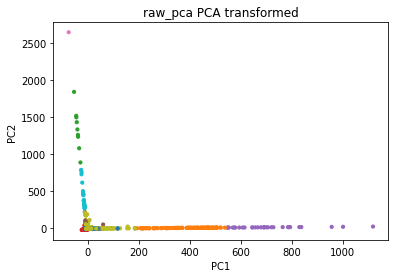





Doing majority for: normalized
Cluster 2: Ciliated_cells (0.86)
Cluster 6: B_cells (0.80)
Cluster 7: Club_cells (0.51)
Cluster 5: CD8+_T_cells (0.42)
Cluster 0: Interstitial_macrophages (0.18)
Cluster 9: Type_2_pneumocytes (0.90)
Cluster 1: vascular_endothelial_cells (0.55)
Cluster 4: Mesothelial_cells (0.55)
Cluster 3: low_quality_cells (0.69)
Cluster 8: Alveolar_macrophage (0.86)




Doing majority for: normalized_pca
Cluster 4: Ciliated_cells (0.86)
Cluster 7: B_cells (0.61)
Cluster 9: Club_cells (0.50)
Cluster 2: CD8+_T_cells (0.44)
Cluster 8: Interstitial_macrophages (0.20)
Cluster 3: Type_2_pneumocytes (0.90)
Cluster 5: vascular_endothelial_cells (0.54)
Cluster 0: Mesothelial_cells (0.55)
Cluster 1: Alveolar_macrophage (0.86)
Cluster 6: low_quality_cells (0.71)


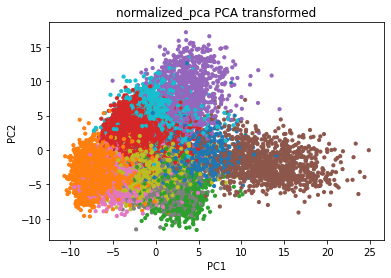

In [23]:
for i, (mat, name) in enumerate(zip(mats, ["raw", "raw_pca", "normalized", "normalized_pca"])):
    print(f"Doing majority for: {name}")
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10).fit(mat)
    labels = kmeans.labels_
    maj = majority_cell_type(labels)
    for cluster in maj:
        print(f"Cluster {cluster}: {maj[cluster]['type']} ({maj[cluster]['proportion']:.2f})")
    
    if i == 1 or i == 3:
        plt.figure()
        plt.scatter(mats[i][:, 0], mats[i][:, 1], c=labels, cmap='tab10', s=10)
        plt.title(f'{name} PCA transformed')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.show()
    print("\n\n\n")


The normalized seems much more spatially organized vs the raw, which is more linear in nature forming a v almost. There is more overlap with the normalized as well. Also, the majority cells change between the two. 

# **d) Age prediction (60 points)**

In their work, [Ilias Angelidis, Lukas M. Simon et al.](https://www.nature.com/articles/s41467-019-08831-9) found that the gene expression pattern for some cell types were different between the two age groups (3 months and 24 months), as shown in the figure below. In the figure below, the x-axis represent different genes and the y-axis represent different cell types, with each color bar representing the logarithm of the fold change in expression level between old and young cells for a particular genes in a particular cell type. Inspired by this result, we will build classification models (using normalized counts) and test how well they can predict the age of a mouse based on the gene expression profile of a single cell.

<center><img src="https://drive.google.com/uc?export=view&id=17gt0rkWzJmh11GPw6ipehM6miiGTD86e" alt="EMFigure" width="550" height="500"><center>

We will compare the predictive power of two different classes of models: (1) logistic regression and (2) neural network. For each class, we will fit a model using gene expression data from a single cell type to predict the age (3m or 24m) of the mouse from which the cell was taken.

**i) From the given information, what cell type would you choose to build a predictive model of mouse age? Explain your reasoning (10 points)**


**Your Answer Here:** 


I would choose a cell type that has some clear distinction between old/young mice, as that would allow for clear clusters and classification. There are several options here, like type_2-pneumocytes, mki67 proliferating cells, B_cells, etc.


To standardize the workflow, we will consider just two cell types: 

(1) 'Alveolar_macrophage' (AM)

(2) 'Type_2_pneumocytes' (T2P) 

For the rest of the question, you will build a total of **4** models: 

1.   logistic regression using alveolar macrophage 
2.   logistic regression using type II pneumocytes 
3.   neural network using alveolar macrophage
4.   neural network using type II pneumocytes

We first subset our **normalized count matrix** to get out count data for alveolar macrophages (AM) and type II pneumocytes (T2P) sampled from 3 months and 24 months mouse, as well as the corresponding age/label for each cell. AM_3m represents alveolar macrophages from a 3 months old mouse, T2P_24m represents type II pneumocytes from a 24 months old mouse. *Note that we are representing the age class '3m' using the integer 0 and the age class '24m' using the integer 1.*

In [24]:
typename = 'Alveolar_macrophage'
youngIndex = meta.grouping.isin(['3m'])*meta.celltype.isin([typename])
oldIndex = meta.grouping.isin(['24m'])*meta.celltype.isin([typename])

# we will assign the number 0 to the age class '3m' and 1 to the age class '24m'
AM_3m = normalize[youngIndex,:]
AM_3m_label = np.zeros(np.size(AM_3m,0))
AM_24m = normalize[oldIndex,:]
AM_24m_label = np.ones(np.size(AM_24m,0))

typename = 'Type_2_pneumocytes'
youngIndex = meta.grouping.isin(['3m'])*meta.celltype.isin([typename])
oldIndex = meta.grouping.isin(['24m'])*meta.celltype.isin([typename])

T2P_3m = normalize[youngIndex,:]
T2P_3m_label = np.zeros(np.size(T2P_3m,0))
T2P_24m = normalize[oldIndex,:]
T2P_24m_label = np.ones(np.size(T2P_24m,0))

Next, we will split our data evenly into a training set and test set. To allow for a fair comparison between the two cell types, we will use the same number of cells for alveolar macrophage as type II pneumocytes. **Use the code block below to split the data for each cell type into a train set and a test set, make sure you split both the gene expression counts and the corresponding labels.** For both cell types, the training set will consist of the first 550 cells of the 3 month old mouse and the first 250 cells of the 24 month old, the test set will consist of the subsequent 550 cells of the 3 month old mouse and the subsequent 250 cells of the 24 month old mouse.

In [25]:

AM_train = np.concatenate((AM_3m[:550, :], AM_24m[:250, :]), axis=0)
AM_trainlabel = np.concatenate((AM_3m_label[:550], AM_24m_label[:250]), axis=0)
AM_test = np.concatenate((AM_3m[550:, :], AM_24m[250:, :]), axis=0)
AM_testlabel = np.concatenate((AM_3m_label[550:], AM_24m_label[250:]), axis=0)

T2P_train = np.concatenate((T2P_3m[:550, :], T2P_24m[:250, :]), axis=0)
T2P_trainlabel = np.concatenate((T2P_3m_label[:550], T2P_24m_label[:250]), axis=0)
T2P_test = np.concatenate((T2P_3m[550:, :], T2P_24m[250:, :]), axis=0)
T2P_testlabel = np.concatenate((T2P_3m_label[550:], T2P_24m_label[250:]), axis=0)


 **ii) Logistic regression models (10 points)**

 In this section, you will build a logistic regression model to classify mouse age and use it to predict the age of the mouse from the gene expression profile of a cell. Recall that with logistic regression we model a categorical variable (e.g. mouse age - 3m vs 24m) as a continuous value (i.e. the probability of being in the category). In our case, the independent variable will be the collection of count data across all 2000 genes and the dependent variable will be a binary variable, 0 or 1, representing whether the cell was from the 24 month old mouse.

**For each cell type (AM and T2P), complete the code block below where you will need to:**

1) fit a logistic regression model using the training set you created above (hint: you may need to change certain hyperparameter to get convergence)

3) evaluating your logistic regression model on the corresponding test set (make sure to use the same cell type as you used to fit the model)

4) report the test accuracy of your model as the percent of cells where the age of the mouse was correctly predicted by the model

In [26]:
from sklearn.linear_model import LogisticRegression
#Set up model for AM 
AM_lr = LogisticRegression(random_state=0, max_iter=10000).fit(AM_train, AM_trainlabel)


#Evaluate logistic regression model on the AM test set
AM_lr_score = AM_lr.score(AM_test, AM_testlabel)

#Report test accuracy of AM model
print(f'Test Accuracy: {AM_lr_score}')

Test Accuracy: 0.8495575221238938


In [27]:
#Set up model for T2P
T2P_lr = LogisticRegression(random_state=0, max_iter=10000).fit(T2P_train, T2P_trainlabel)


#Evaluate logistic regression model on the T2P test set
T2P_lr_score = T2P_lr.score(T2P_test, T2P_testlabel)

#Report test accuracy of T2P model
print(f'Test Accuracy: {T2P_lr_score}')

Test Accuracy: 0.745219182112386


**iii) Neural network models - use the code/function below (30 points)**

In this section, we will try to predict mouse age by building a Multi-Layer Perceptron (MLP) Model using [Pytorch](https://pytorch.org/docs/stable/index.html). Our MLP will take as input the expression level of the 2000 highly variable genes for a given cell and produce a pair of values corresponding to the probability of the cell being obtain from a 3 months vs. 24 months mouse. Specifically, we will train two separate neural networks using different cell types, one using **alveolar macrophages** and another using **type II pneumocytes**

We will start by first importing packages and initialize the random number generator to a fixed constant to ensure reproducibility.

In [28]:
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

seed = 183
torch.manual_seed(seed)

#### We will first construct our **neural network model for alveolar macrophages**

When we train and evaluate our model, we will require batches of data to be provided. The Dataloader class can automatically provide batches of data fetched from a `Dataset` objects (which is defined for you as a `CountDataset` class). **Complete the code block below by converting counts and labels into tensors of the appropriate type.** In order for training to run properly, you need to make sure to convert count data to [`tensor` objects](https://pytorch.org/docs/stable/tensors.html#torch.Tensor) of type Float and the labels (age) should also be `tensor` objects of type Integer. **Furthermore, set an appropriate batch size, nbatch.** The batch size represents the number of samples passed through our neural network before an error gradient is computed and the network parameters are updated.

In [29]:
#create a custom dataset object so we can use dataloader for shuffling the data
class CountDataset(Dataset):
    def __init__(self, count, labels):
        self.labels = labels
        self.count = count
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        count = self.count[idx]
        sample = [count, label]
        return sample

# convert counts/label into tensors of the appropriate type
traindata = torch.tensor(AM_train, dtype=torch.float32)
trainlabel = torch.tensor(AM_trainlabel, dtype=torch.int64)
testdata = torch.tensor(AM_test, dtype=torch.float32)
testlabel = torch.tensor(AM_testlabel, dtype=torch.int64)

trainset = CountDataset(count=traindata, labels=trainlabel)
testset = CountDataset(count=testdata, labels=testlabel)

# create data loaders
nbatch = 64
trainloader = DataLoader(trainset, batch_size=nbatch, shuffle=True)
testloader = DataLoader(testset, batch_size=nbatch, shuffle=True)

We are now ready to create our simple neural network model. We will define our model in a class that extends nn.Module. nn.Module subclasses must do a minimum of one thing: implement the forward method which takes a batch of data and performs the forward-pass. PyTorch's autograd system computes the gradients of the forward pass for us. In the code below we'll also make use of the constructor of our model to instantiate the hidden and output layers.The model is a simple neural network with one hidden layer. A rectifier linear unit (ReLU) activation function is used for the neurons in the hidden layer. The nn.Module class defines a instance variable called training that is set to True when the model is being trained and False when it is being evaluated after being trained. Since we would like our output to represent probabilities of the cell being from either of the two age groups (outputs are between 0 and 1, and sum up to 1), we can use the [softmax activation function](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html#torch.nn.functional.softmax) on our output layer to turn the outputs into probability-like values. **Complete the code below by implementing the softmax function on the output when the model is not being trained.** We do this because we will use PyTorch's implementation of Cross Entropy Loss (nn.CrossEntropyLoss) during training which implicitly adds a softmax before a logarithmic loss.

In [30]:
# define MLP model
class MLPmodel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPmodel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
          out = F.softmax(out, dim=1)
        return out

We can now fit and evaluate the model. **In the code below, complete the implementation of the training loop by**

(1) Initialize an instance of our MLPmodel class using appropriate choices of the input_size, hidden_size, and num_classes.

(2) Define the variables named loss_function and optimiser, we will use the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) and the [ADAM optimiser](https://pytorch.org/docs/stable/optim.html).

(3) Pick an appropriate number of epoch to train for.

(4) Make a line plot showing the loss across all training epochs.

Epoch 1 loss: 7.4086606204509735
Epoch 2 loss: 4.847661271691322
Epoch 3 loss: 3.120287448167801
Epoch 4 loss: 2.1503743827342987
Epoch 5 loss: 1.6560628861188889
Epoch 6 loss: 1.2993976101279259
Epoch 7 loss: 0.9873489327728748
Epoch 8 loss: 0.8055684641003609
Epoch 9 loss: 0.6623777821660042
Epoch 10 loss: 0.5192169342190027
Epoch 11 loss: 0.41920996084809303
Epoch 12 loss: 0.33845719415694475
Epoch 13 loss: 0.2785053001716733
Epoch 14 loss: 0.2345069288276136
Epoch 15 loss: 0.2014786577783525
Epoch 16 loss: 0.16505585052073002
Epoch 17 loss: 0.13834169879555702
Epoch 18 loss: 0.12132660113275051
Epoch 19 loss: 0.09926860826089978
Epoch 20 loss: 0.09039208851754665


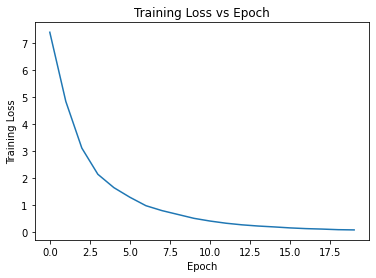

In [31]:
# build the model 
input_size = traindata.shape[1]
hidden_size = 50
num_classes = 2
model = MLPmodel(input_size, hidden_size, num_classes)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

# define number of epochs to train for
nepoch = 20

# the epoch loop
train_losses = []
for epoch in range(nepoch):
    running_loss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()
    train_losses.append(running_loss)
    print(f'Epoch {epoch+1} loss: {running_loss}')
# plot epoch vs loss
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.show()


Let's evaluate the overall accuracy of our trained network on our test set. Use the following code block to finish implementation of the accuracy computation. Report the test accuracy as the percent of cells where the age of the mouse was correctly predicted by the trained MLP model. Note that before the code you need to implement we've made a call to model.eval() - this sets the model into evaluation mode and supresses non-training things (gradients, dropout being applied/computed, etc.).

In [32]:
model.eval()

# Compute the model accuracy on the test set
ncorrect = 0
ntotal = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        ncorrect += (predicted == labels).sum().item()
        ntotal += len(labels)

neural_test_acc_AM = (100.0 * ncorrect) / ntotal
print('Test Accuracy: %2.2f %%' % ((100.0 * ncorrect) / ntotal))

Test Accuracy: 85.95 %


**Repeat the steps above for type II pneumocytes. Use the exact same set of hyperparameters you set for training on alveolar macrophages.**

**Show all your code and report the following**:

(1) A loss curve showing the loss value for each epoch

(2) Test accuracy on the T2P test set

Epoch 1 loss: 7.539492219686508
Epoch 2 loss: 4.839554250240326
Epoch 3 loss: 3.2152328193187714
Epoch 4 loss: 2.198642559349537
Epoch 5 loss: 1.530181784182787
Epoch 6 loss: 1.1358840055763721
Epoch 7 loss: 0.8328085970133543
Epoch 8 loss: 0.6337338481098413
Epoch 9 loss: 0.5135208908468485
Epoch 10 loss: 0.38716583512723446
Epoch 11 loss: 0.3103238856419921
Epoch 12 loss: 0.24823023471981287
Epoch 13 loss: 0.19980482384562492
Epoch 14 loss: 0.1640602145344019
Epoch 15 loss: 0.13495927024632692
Epoch 16 loss: 0.11365924356505275
Epoch 17 loss: 0.09821015922352672
Epoch 18 loss: 0.08681260189041495
Epoch 19 loss: 0.07467197300866246
Epoch 20 loss: 0.06953355553559959


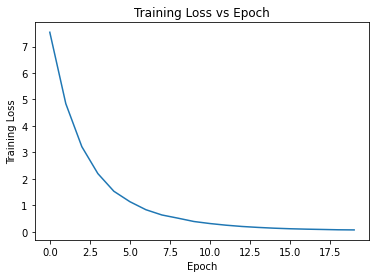

Test Accuracy: 74.49 %


In [33]:
traindata = torch.tensor(T2P_train, dtype=torch.float32)
trainlabel = torch.tensor(T2P_trainlabel, dtype=torch.int64)
testdata = torch.tensor(T2P_test, dtype=torch.float32)
testlabel = torch.tensor(T2P_testlabel, dtype=torch.int64)

trainset = CountDataset(count=traindata, labels=trainlabel)
testset = CountDataset(count=testdata, labels=testlabel)

# create data loaders
nbatch = 64
trainloader = DataLoader(trainset, batch_size=nbatch, shuffle=True)
testloader = DataLoader(testset, batch_size=nbatch, shuffle=True)

# train the same MLP model used above for T2P
# build the model 
input_size = traindata.shape[1]
hidden_size = 50
num_classes = 2
model = MLPmodel(input_size, hidden_size, num_classes)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

# define number of epochs to train for
nepoch = 20

# the epoch loop
train_losses = []
for epoch in range(nepoch):
    running_loss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()
    train_losses.append(running_loss)
    print(f'Epoch {epoch+1} loss: {running_loss}')



# plot loss across epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.show()

# report model accuracy on T2P test set
model.eval()

# Compute the model accuracy on the test set
ncorrect = 0
ntotal = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        ncorrect += (predicted == labels).sum().item()
        ntotal += len(labels)

neural_test_acc_T2P = (100.0 * ncorrect) / ntotal
print('Test Accuracy: %2.2f %%' % ((100.0 * ncorrect) / ntotal))

**iv) Make a bar plot showing the test accuracy across all four models that you built. (10 points)**

You can use https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html 

1.   logistic regression using alveolar macrophage 
2.   logistic regression using type II pneumocytes 
3.   neural network using alveolar macrophage
4.   neural network using type II pneumocytes

Text(0.5, 1.0, 'Test Acc of models')

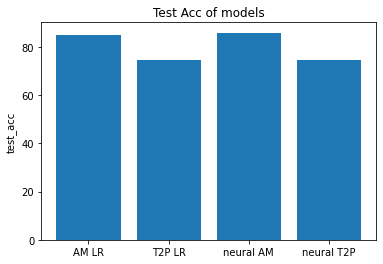

In [34]:
# make bar plot
# ENTER CODE HERE
accs = [AM_lr_score*100,T2P_lr_score*100, neural_test_acc_AM, neural_test_acc_T2P]
names = ['AM LR', 'T2P LR', 'neural AM', 'neural T2P']

plt.bar(names, accs)  
plt.ylabel("test_acc")
plt.title("Test Acc of models")
